<a href="https://colab.research.google.com/github/szn5400/IST_HW3/blob/main/IST_HW3_Final_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_val = x_train[50000:60000]
y_val = y_train[50000:60000]
x_train = x_train[0:50000]
y_train = y_train[0:50000]

In [ ]:
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.datasets import mnist

# Define the One-hot Encoder
ohe = preprocessing.OneHotEncoder()

# Load MNIST data
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape data
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Fit and transform training data
ohe.fit(y_train)
transformed_train = ohe.transform(y_train).toarray()

# Fit and transform training data
ohe.fit(y_val)
transformed_val = ohe.transform(y_val).toarray()

# Fit and transform testing data
ohe.fit(y_test)
transformed_test = ohe.transform(y_test).toarray()

In [ ]:
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(transformed_train.shape))
print('X_val: ' + str(x_val.shape))
print('Y_val: ' + str(transformed_val.shape))
print('X_test:  '  + str(x_test.shape))
print('Y_test:  '  + str(transformed_test.shape))

X_train: (50000, 28, 28)
Y_train: (50000, 10)
X_val: (10000, 28, 28)
Y_val: (10000, 10)
X_test:  (10000, 28, 28)
Y_test:  (10000, 10)


In [ ]:
train_X_mod = x_train.reshape(50000, 784)
train_y_mod = transformed_train
val_X_mod = x_val.reshape(10000, 784)
val_y_mod = transformed_val
test_X_mod = x_test.reshape(10000, 784)
test_y_mod = transformed_test

In [ ]:
size_input = 784
size_hidden1 = 512
size_hidden2 = 256
size_output = 10
number_of_train_examples = 50000
number_of_val_examples = 10000
number_of_test_examples = 10000

In [ ]:
import tensorflow as tf
X_train = tf.keras.utils.normalize(train_X_mod, axis=1)
y_train = train_y_mod
X_val = tf.keras.utils.normalize(val_X_mod, axis=1)
y_val = val_y_mod
X_test = test_X_mod
y_test = test_y_mod 

In [ ]:
import os
import numpy as np
import time

np.random.seed(43)
tf.random.set_seed(43)
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(4)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

In [ ]:
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of hidden layer 1
    size_hidden2: int, size of hodden layer 2
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1]))
    # Initialize weights between input layer and hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    self.t=0
    self.mt=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32)]
    self.vt=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32)]
    self.ut=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32)]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    #return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)
    #print(y_true_tf)
    #print(y_pred_tf)
    cce = tf.keras.losses.CategoricalCrossentropy()
    loss_val = cce(y_true_tf, y_pred_tf)
    regularizer = tf.nn.l2_loss(self.W1)+tf.nn.l2_loss(self.W2)
    loss_val = tf.reduce_mean(loss_val + 0.01 * regularizer)
    
    #print(loss_val)
    return loss_val

  def accuracy(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    #y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    y_pred_tf = tf.cast(tf.reshape(y_pred, (-1, self.size_output)), dtype=tf.float32)
    print(y_true_tf)
    print(y_pred_tf)
    ## CALCULATING COST AND ACCURACY
    #cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_preds, labels=y))
    #optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    #print(correct_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    #print(ac)
    return accuracy
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    #y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    y_pred_tf = tf.cast(tf.reshape(y_pred, (-1, self.size_output)), dtype=tf.float32)    
    correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    #print(correct_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    #print(accuracy)
    return accuracy
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    '''
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
    '''
    self.t=self.t+1
    alpha = 1e-3
    beta_1=0.9
    beta_2=0.999
    beta_3=0.999987
    eps=1e-8
    eps2 = 1e-1 
    
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    #grads = grads+eps2
    #print(grads)
    #print(len(grads[0]))
    #print(len(grads[1]))
    #print(len(self.m[0]))
    #print(len(self.m[1]))

    self.mt=[m_val*beta_1+(1-beta_1)*g for m_val, g in zip(self.mt, grads) ]
    self.vt=[v_val*beta_3+(1-beta_3)*(g**3) for v_val, g in zip(self.vt, grads) ]
    self.ut=[u_val*beta_2+(1-beta_2)*(g**2) for u_val, g in zip(self.ut, grads) ]
    '''
    print('MT')
    print(self.mt)
    print('VT')
    print(self.vt)
    print('UT')
    print(self.ut)
    '''

    mt_hat=[m_val/(1-(beta_1**self.t)) for m_val in self.mt]
    vt_hat=[v_val/(1-(beta_3**self.t)) for v_val in self.vt]
    ut_hat=[u_val/(1-(beta_2**self.t)) for u_val in self.ut]
    
    
    dws_new = [(alpha * m_val /(np.sqrt(np.abs(v_val))+(np.power(np.abs(u_val),0.3333)*eps)+eps2)) for m_val, v_val, u_val in zip(mt_hat,vt_hat,ut_hat)]
    #dws_new = [(alpha * m_val /(eps2)) for m_val, v_val, u_val in zip(mt_hat,vt_hat,ut_hat)]
    #print('dws_new')
    #print(dws_new)
    Wt = [wt - d for wt,d in zip(self.variables, dws_new)]
    #print(Wt)
    W1 = self.variables[0]
    W1.assign(Wt[0])
    W2 = self.variables[1]
    W2.assign(Wt[1])
    W3 = self.variables[2]
    W3.assign(Wt[2])
    b1 = self.variables[3]
    b1.assign(Wt[3])
    b2 = self.variables[4]
    b2.assign(Wt[4])
    b3 = self.variables[5]
    b3.assign(Wt[5])       
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1_1 = tf.nn.dropout(hhat1, 0.25)

    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1_1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2_1 = tf.nn.dropout(hhat2, 0.25)
    
    # Compute output
    output = tf.matmul(hhat2_1, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    output = tf.nn.softmax(output)
    return output

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_output, device='cpu')

# Array to store accuracy and loss
loss_with_epoch = []
acc_with_epoch = []
loss_with_epoch_val = []
acc_with_epoch_val = []

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  ac = 0
  count = 0
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(1234)).batch(20)
  val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(25, seed=epoch*(1234)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    ac = ac+mlp_on_cpu.accuracy(preds, outputs)
    #ac = mlp_on_cpu.accuracy(preds, outputs)
    count += 1
  print('Number of Epoch = {} - Average celoss:= {}- Acc:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0], ac/count))
  loss_with_epoch.append(np.sum(loss_total) / X_train.shape[0])
  acc_with_epoch.append(ac/count)
  for inputs, outputs in val_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    ac = ac+mlp_on_cpu.accuracy(preds, outputs)
    #ac = mlp_on_cpu.accuracy(preds, outputs)
    count += 1
  print('Number of Epoch = {} - Average celoss:= {}- Acc:= {} '.format(epoch + 1, np.sum(loss_total) / X_val.shape[0], ac/count))
  loss_with_epoch_val.append(np.sum(loss_total) / X_train.shape[0])
  acc_with_epoch_val.append(ac/count)
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average celoss:= 1.118972109375- Acc:= 0.6280400156974792 
Number of Epoch = 1 - Average celoss:= 6.40759921875- Acc:= 0.658483624458313 
Number of Epoch = 2 - Average celoss:= 0.6178684375- Acc:= 0.8251408338546753 
Number of Epoch = 2 - Average celoss:= 3.55005- Acc:= 0.8315160870552063 
Number of Epoch = 3 - Average celoss:= 0.356305078125- Acc:= 0.851340115070343 
Number of Epoch = 3 - Average celoss:= 2.05098359375- Acc:= 0.8556656241416931 
Number of Epoch = 4 - Average celoss:= 0.21323380859375- Acc:= 0.8643994331359863 
Number of Epoch = 4 - Average celoss:= 1.230876171875- Acc:= 0.867364764213562 
Number of Epoch = 5 - Average celoss:= 0.134441044921875- Acc:= 0.8715370297431946 
Number of Epoch = 5 - Average celoss:= 0.779169287109375- Acc:= 0.8738956451416016 
Number of Epoch = 6 - Average celoss:= 0.09097037109375- Acc:= 0.874337911605835 
Number of Epoch = 6 - Average celoss:= 0.52984697265625- Acc:= 0.8768120408058167 
Number of Epoch = 7 - Average c

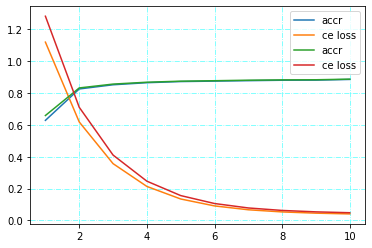

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = [i for i in range(1,11)]
line1, = plt.plot(x, acc_with_epoch, label='accr')
line2, = plt.plot(x, loss_with_epoch, label='ce loss')
line3, = plt.plot(x, acc_with_epoch_val, label='accr')
line4, = plt.plot(x, loss_with_epoch_val, label='ce loss')
#plt.plot(x, acc_with_epoch, label='accr')
plt.legend(handles=[line1, line2, line3, line4], loc='best')
plt.grid(b=True, color='aqua', alpha=0.6, linestyle='dashdot')
plt.show()

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  ac = mlp_on_cpu.accuracy(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test celoss: {:.4f} and accuracy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_train.shape[0], ac))

Test celoss: 0.2617 and accuracy: 0.5000
